In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
%matplotlib inline

In [2]:
# algorithm of cone output with horizontal cell feedback
def ConeOutput(x,phi):
    alpha_c=2.4e-4 #-9.602e-6 in paper but used 2.4e-4 in code
    beta_c=1.148e-5
    alpha_h=.5292
    gamma=.764
    tau_h=.371
    tau_z=.5769
    tau_y=.056
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    Ky=Ky/np.sum(Ky)
    Kz=Kz/np.sum(Kz)
    Kh=Kh/np.sum(Kh)
    plt.plot(Ky)
    plt.plot(Kz)
    plt.plot(Kh)
    plt.show()
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    # calculate the convolution between h and Kh, same as equation 12
    for i in range(len(x)-1): 
        if i-len(Kh)+1<0:
            Kht=Kh[::-1][-i-1:len(Kh)]
            h[i]=alpha_h*sum(Kht*r[0:len(Kht)])
        else:
            Kht=Kh[::-1]
            h[i]=alpha_h*sum(Kht*r[i-len(Kht)+1:i+1])
        
        # calculate cone cell output, same as equation 11 
        r[i]=alpha_c*y[i]/(1+beta_c*z[i])-phi*h[i]
    return r,h

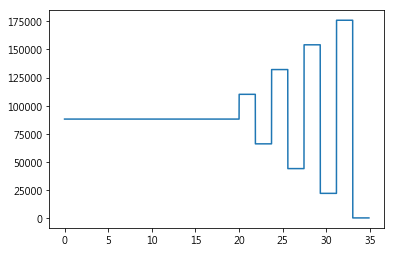

In [3]:
# Stimulus
# precise light level from paper
dt=0.001
ad=20
du=1.86
LightLevelList=[88166.6666666667,110129.166666667,66204.1666666667,132091.666666667,44241.6666666667,154054.166666667,\
22279.1666666667,175840.966666667,492.366666666652] # absolute light intensity
adaptation=np.ones(int(ad/dt))
sti=np.ones(int(du/dt))
x=LightLevelList[0]*adaptation
for i in range(8):
    x=np.append(x,LightLevelList[i+1]*sti)
T=np.arange(dt,ad+du*8+1e-7,dt)
plt.plot(T,x)
plt.show()

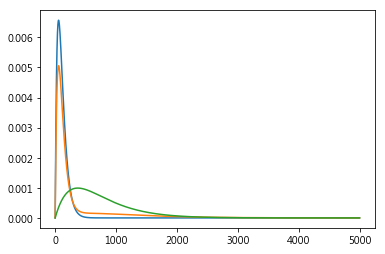

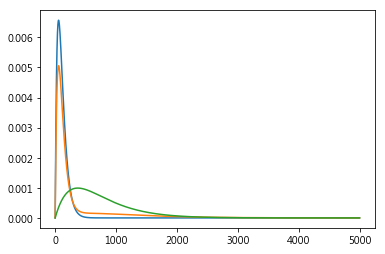

In [4]:
r,h=ConeOutput(x,1)
rb,hb=ConeOutput(x,0)
# r2,h2=ConeOutput2(x,1)
# r2b,h2b=ConeOutput2(x,0)
# r_RK,h_RK=ConeOutput_RK(T,x,1)

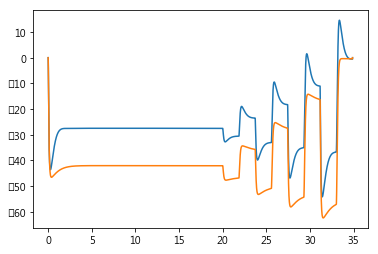

In [5]:
# figure 7C
plt.plot(T,-4*r) # the cone output is multiplied by -4 in their code (I'm not sure why)
plt.plot(T,-4*rb)
plt.xlim()
plt.ylim()
plt.show()

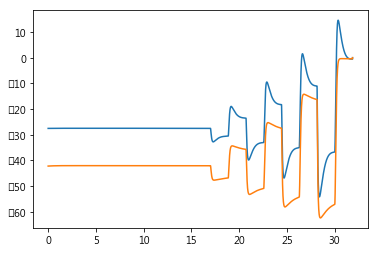

In [6]:
# remove a time duration in the beginning
r1=-4*r[T>3]
rb1=-4*rb[T>3]
T1=T[T>3]-3
plt.plot(T1,r1)
plt.plot(T1,rb1)
plt.show()

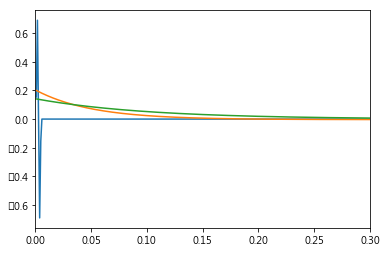

In [7]:
# kernels of bipolar pathway
# K1 for Fast pathway; K2 for Intermediate pathway; K3 for Slow pathway
mu=3e-3
sigma=1e-3
tau2=5e-2
tau3=1e-1
c2=50
TK=np.arange(dt,10,dt)
K1=np.sin(math.pi*TK/mu)/np.sqrt(2*math.pi*sigma)*np.exp(-1/2*((TK-mu)/sigma)**2)
K2=np.exp(-TK/tau2)/tau2-np.exp(-TK/c2/tau2)/c2/tau2
K3=np.exp(-TK/tau3)/tau3

K1=K1/np.sqrt(np.sum(K1**2))
K2=K2/np.sqrt(np.sum(K2**2))
K3=K3/np.sqrt(np.sum(K3**2))
plt.plot(TK,K1)
plt.plot(TK,K2)
plt.plot(TK,K3)
plt.xlim(0,0.3)
plt.show()

In [8]:
# figure 7E 
def bipolar(r_in):
    v_dark=23
    K_1_2_3=[K1,K2,K3]
    theta_p_k=[[0.1,-0.1],[0,0],[-23.5,-23.5]] # theta_p_k = theta[p][k]
    b_p_k=[[[] for i in range(2)] for j in range(3)]
    r_baseline=r_in+v_dark
    for k in range(2):
        for p in range(3):
            btemp=(-1)**k*(np.convolve(r_baseline,K_1_2_3[p],'full')-theta_p_k[p][k])
            btemp=btemp[0:len(r_baseline)]
            btemp[btemp<0]=0
            btemp[T1<0.01]=0
            b_p_k[p][k]=np.array(btemp)
    return b_p_k

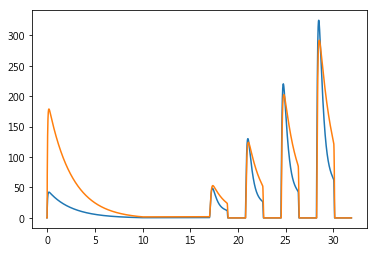

In [9]:
# figure 7E bipolar cell output
br=bipolar(r1)
brb=bipolar(rb1)
plt.plot(T1,br[1][1])
plt.plot(T1,brb[1][1]) 
# plt.xlim(27,30)
# plt.ylim(0,3000)
plt.show()

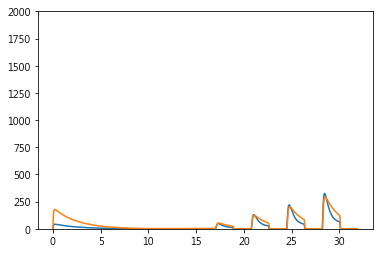

In [10]:
plt.plot(T1,br[1][1])
plt.plot(T1,brb[1][1]) 
# plt.xlim(27,30)
plt.ylim(0,2000)
plt.show()

In [11]:
#calculate ganglion cell output figure 7B
def rgc(w_gpk,alpha_g,theta_g,b):
    Ig=0
    for p in range(np.size(w_gpk,0)):
        for k in range(np.size(w_gpk,1)):
            Ig=Ig+w_gpk[p][k]*b[p][k]
    Kg=np.copy(K1)
    Ig_velocity=np.convolve(Ig,Kg,'full')
    Ig_velocity=Ig_velocity[0:len(Ig)]
    R=(1-alpha_g)*Ig+alpha_g*Ig_velocity-theta_g
    R[R<0]=0
    return R

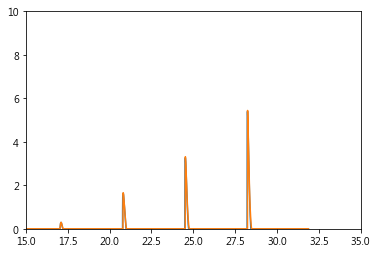

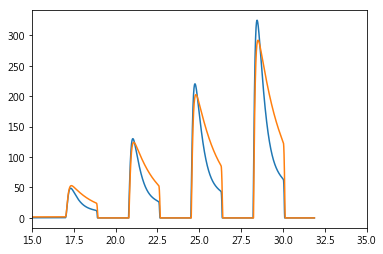

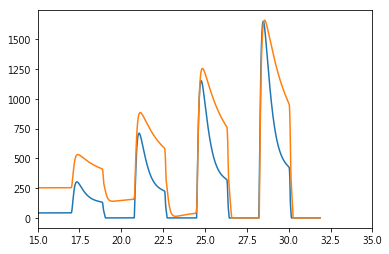

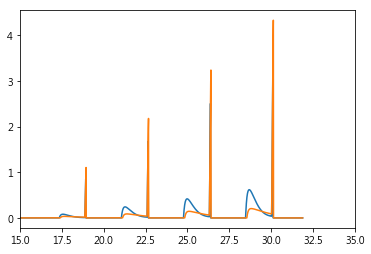

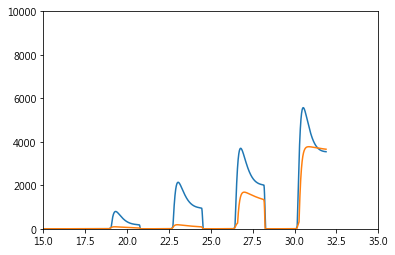

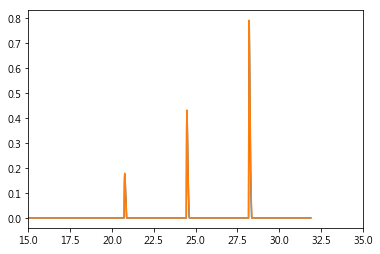

In [12]:
w1=[[0 for i in range(2)] for j in range(3)]
w1[1][1]=1
R1=rgc(w1,1,.3,br)
R1b=rgc(w1,1,.3,brb)
plt.plot(T1,R1)
plt.plot(T1,R1b)
plt.xlim(15,35)
plt.ylim(0,10)
plt.show()

w2=[[0 for i in range(2)] for j in range(3)]
w2[1][1]=1
R2=rgc(w2,0,.1,br)
R2b=rgc(w2,0,.1,brb)
plt.plot(T1,R2)
plt.plot(T1,R2b)
plt.xlim(15,35)
plt.ylim()
plt.show()

w3=[[0 for i in range(2)] for j in range(3)]
w3[1][1]=4 # value is slightly different from the paper
w3[2][1]=1
R3=rgc(w3,0,0,br)
R3b=rgc(w3,0,0,brb)
plt.plot(T1,R3)
plt.plot(T1,R3b)
plt.xlim(15,35)
plt.show()

w4=[[0 for i in range(2)] for j in range(3)]
w4[0][0]=3
w4[1][1]=-1
R4=rgc(w4,1,0,br)
R4b=rgc(w4,1,0,brb)
plt.plot(T1,R4)
plt.plot(T1,R4b)
plt.xlim(15,35)
plt.show()

w5=[[0 for i in range(2)] for j in range(3)]
w5[1][0]=1
w5[2][0]=10
R5=rgc(w5,0,-0.1,br)
R5b=rgc(w5,0,-0.1,brb)
plt.plot(T1,R5)
plt.plot(T1,R5b)
plt.xlim(15,35)
plt.ylim(0,10000)
plt.show()

w6=[[0 for i in range(2)] for j in range(3)]
w6[0][1]=1
R6=rgc(w6,0,0,br)
R6b=rgc(w6,0,0,brb)
plt.plot(T1,R6)
plt.plot(T1,R6b)
plt.xlim(15,35)
plt.show()

In [13]:
# # plot the final result again 
# fig, ax1=plt.subplots(figsize=(8,6))
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('Ganglion cell output', color='tab:orange')
# ax1.plot(T1,R1,color='tab:orange')
# ax1.plot(T1,R1b,color='tab:orange',linestyle='dashed')
# ax1.tick_params(axis='y',labelsize=16,labelcolor='tab:orange')